## Import des librairies

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import researchpy as rp
import scipy.stats as stats
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from pingouin import kruskal
from sklearn.linear_model import LogisticRegression
from optbinning import BinningProcess
from sklearn.cluster import KMeans
import lightgbm as lgb
from sklearn.metrics import roc_curve, auc
import re
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
sns.set_style(style = "darkgrid")
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from model_fonctions import stepwise_selection, str_to_int, kruskal_test, chi2, corr_entre_quanti, encode_par_tx_defaut, plot_roc_curve
from fonctions_date import create_date_periods
from stabilite_graphics_tools import plot_stabilite_risque, plot_stabilite_effectif

## Import du dataframe

In [2]:
#df = pd.read_csv('Bases_recents.csv', index_col='Unnamed: 0')
df=pd.read_csv('data/Bases_recents.csv', sep = ';')
df.head(3)
df.drop(columns="Unnamed: 0", axis = 1)

,region_cri,date_debloc_avec_crd,DAT_VALIDE_ACCORD_CRI,nb_pret,TOP_CONNU_BRP,TOP_SCI_BRP,ASU_BIEN_FIN_BRP,NAT_BIEN_FIN_BRP,NBR_INT_BRP,NBR_TOT_COEMPR_CRI,...,Mt_credit_nb_ans_rev_prof,Epargne_nb_ans_rev_prof,rentabilite_loc,financement_tot,quotite,top_locatif,top_pret_int_ext,top_autre_pret_int,top_autre_pret_ext,top_pers_seule
0,ILE DE FRANCE,201405,2010-12-01,1,0,0,40,10,2,1,...,3.140729,NaN,NaN,301510.0,1.083166,1,0,0,0,1
1,ILE DE FRANCE,201405,2011-03-14,2,0,0,10,10,2,1,...,0.999205,NaN,NaN,190962.0,0.310507,0,0,0,0,0
2,PACA,201407,2011-06-21,1,0,0,40,20,1,0,...,4.375182,NaN,NaN,105000.0,1.000000,1,0,0,0,1
3,AUVERGNE,201404,2011-06-27,1,0,0,20,20,2,1,...,2.006637,0.389825,NaN,215280.0,0.800000,0,0,0,0,0
4,ILE DE FRANCE,201404,2011-09-29,3,0,0,10,10,1,0,...,4.536824,0.287687,NaN,177700.0,0.585158,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114411,PAYS DE LA LOIRE,201804,2018-04-06,1,0,0,10,20,2,1,...,3.743370,2.582877,NaN,252670.0,1.052792,0,0,0,0,1
114412,AUVERGNE,201804,2018-03-29,2,0,0,10,10,1,0,...,3.726499,NaN,NaN,244000.0,1.000000,0,0,0,0,1
114413,ILE DE FRANCE,201804,2018-03-28,1,0,0,10,10,2,1,...,6.028812,0.697618,NaN,345680.0,1.002698,0,0,0,0,1
114414,BRETAGNE,201804,2018-03-29,1,0,0,20,20,2,1,...,3.269921,NaN,NaN,147330.0,1.091333,0,0,0,0,0


## Assignation du status pour chaque variable

In [3]:
df_dico = pd.read_excel('Data/Dictionnaire de données modif.xlsx')
df_dico.rename(columns={'Variables brutes ':'variable'}, inplace=True)


dicho = []
cat = []
continu = []
regrouper = []
ordinale = []
reste = []
for i in range(df_dico.shape[0]):
    if df_dico['Colonne1'][i] == 'dicho':
        #print(df_dico['variable'][i])
        dicho.append(df_dico['variable'][i])
    elif df_dico['Colonne1'][i] == 'cat':
        cat.append(df_dico['variable'][i])
    elif df_dico['Colonne1'][i] == 'continu':
        continu.append(df_dico['variable'][i])
    elif df_dico['Colonne1'][i] == 'regrouper':
        regrouper.append(df_dico['variable'][i])
    elif df_dico['Colonne1'][i] == 'ordinale':
        ordinale.append(df_dico['variable'][i])
    else:
        reste.append(df_dico['variable'][i])
        
df.loc[74836, 'DEPARTEMENT_CRI'] = 'NR' # Pour éviter les erreurs

## Preprocessing
### Découpage en train et test

In [4]:
def target_split(df : pd.DataFrame, target_name : str = "defaut_36mois"):
    return df.drop(labels = target_name, axis = 1), df[target_name]

df_train = (df[df["date_debloc_avec_crd"].apply(lambda x:int(str(x)[:4])) < 2017])
df_train.reset_index(drop = True, inplace = True)
X_train, y_train = target_split(df_train)

df_test = (df[df["date_debloc_avec_crd"].apply(lambda x:int(str(x)[:4])) == 2017])
df_test.reset_index(drop = True, inplace = True)
X_test, y_test = target_split(df_test)

df_oos = (df[df["date_debloc_avec_crd"].apply(lambda x:int(str(x)[:4])) == 2018])
df_oos.reset_index(drop = True, inplace = True)
X_oos, y_oos = target_split(df_oos)


print(f"Dimension du train test : {X_train.shape} / {y_train.shape}")
print(f"Dimension du train test : {X_test.shape} / {y_test.shape}")
print(f"Dimension du train test : {X_oos.shape} / {y_oos.shape}")

Dimension du train test : (73303, 123) / (73303,)
Dimension du train test : (35475, 123) / (35475,)
Dimension du train test : (5638, 123) / (5638,)


In [5]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [6]:
# Changement du type de variables
str_to_int(X_train)
str_to_int(X_test)

### Tests statistiques (Kruskal-Wallis et Chi²)

In [7]:
X_train_y_train = pd.concat([X_train, y_train], axis=1)
p_val, continu_significatif_k = kruskal_test(df_train, continu)
print(f"{len(continu_significatif_k)} variables continues significatives selon Kruskal-Wallis")

dicho_significatif = chi2(dicho, X_train_y_train, 0.05)
print(f"{len(dicho_significatif)} variables dichotomiques significatives selon le Chi²")

cat_significatif = chi2(cat, X_train_y_train, 0.01)
print(f"{len(cat_significatif)} variables catégorielles significatives selon le Chi²")

28 variables continues significatives selon Kruskal-Wallis
6 variables dichotomiques significatives selon le Chi²
15 variables catégorielles significatives selon le Chi²


### Test de correlation entre variables continues

In [8]:
X_train_continu_significatif = X_train_y_train[continu_significatif_k]

df_X_continu_train = X_train_continu_significatif.copy()
X_train_continu_significatif_non_corr = corr_entre_quanti(df_X_continu_train)

# Create correlation matrix
corr_matrix = df_X_continu_train.corr('spearman').abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.3)]

# Drop features 
df_X_continu_train.drop(to_drop, axis=1, inplace=True)

df_X_continu_train.columns.to_list()
print(f"{df_X_continu_train.shape[1]} variables continues acceptées sous le seuil de corrélation de 0.3")

10 variables continues acceptées sous le seuil de corrélation de 0.3


## Encoding

In [9]:
#variable_names = cat_significatif + continu_significatif + ordinale + dicho_significatif
variable_names = cat_significatif + df_X_continu_train.columns.to_list() + ordinale + dicho_significatif 
X = X_train[variable_names]

In [10]:
selection_criteria = {"iv":{"min":0.02, "max":1, "strategy":"highest", "top":15},
                      "quality_score": {"min":0.01}
                      }
binning_process = BinningProcess(variable_names, selection_criteria=selection_criteria, categorical_variables=cat_significatif)
binning_process.fit(X, y_train)
variable_a_bin = list(binning_process.get_support(names=True))
print(f"{len(variable_a_bin)-2} variables selectionnées par le WOE")

X_train_t = binning_process.transform(X[variable_a_bin], metric="bins")
X_train_t = X_train_t.drop(labels = ["CODTYP_CRT_TRAVAIL_CRI", "COD_SITU_LOGT_CRI"], axis = 1)

X_test_t = binning_process.transform(X_test[variable_a_bin], metric="bins")
X_test_t = X_test_t.drop(labels = ["CODTYP_CRT_TRAVAIL_CRI", "COD_SITU_LOGT_CRI"], axis = 1)

X_oos_t = binning_process.transform(X_oos[variable_a_bin], metric="bins")
X_oos_t = X_oos_t.drop(labels = ["CODTYP_CRT_TRAVAIL_CRI", "COD_SITU_LOGT_CRI"], axis = 1)

df_a_dummy = pd.concat([X_train_t, X_test_t, X_oos_t], axis = 0)
df_dummy = pd.get_dummies(df_a_dummy.astype('object'), drop_first=True)

X_train_t_dummy = df_dummy.iloc[:X_train.shape[0],:]
X_test_t_dummy = df_dummy.iloc[X_train.shape[0]:X_train.shape[0]+X_test.shape[0], :]
X_oos_t_dummy = df_dummy.iloc[X_train.shape[0] + X_test.shape[0]:,:]

modele_list = chi2(X_train_t_dummy.columns, pd.concat([X_train_t_dummy, y_train], axis = 1), 0.15) # On ne sélectionne que les modalités significatives au sens du chi²
print(f"{len(modele_list)} modalités considérées comme significatives selon le test de Chi²")

9 variables selectionnées par le WOE
33 modalités considérées comme significatives selon le test de Chi²


## Modelisation

In [11]:
# # Choix des hyperparamètres par cross validation -> long à executer
# space = dict()
# space['solver'] = ['newton-cg', 'lbfgs', 'liblinear', 'saga']
# space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
# space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# search = GridSearchCV(LogisticRegression(), space, scoring='roc_auc', n_jobs=-1, cv=cv)

# search.fit(X_train_t, y_train)

In [12]:
lr_search = LogisticRegression(C=1, penalty='l1', solver="liblinear")

lr_search.fit(X_train_t_dummy[modele_list], y_train)

LogisticRegression(C=1, penalty='l1', solver='liblinear')

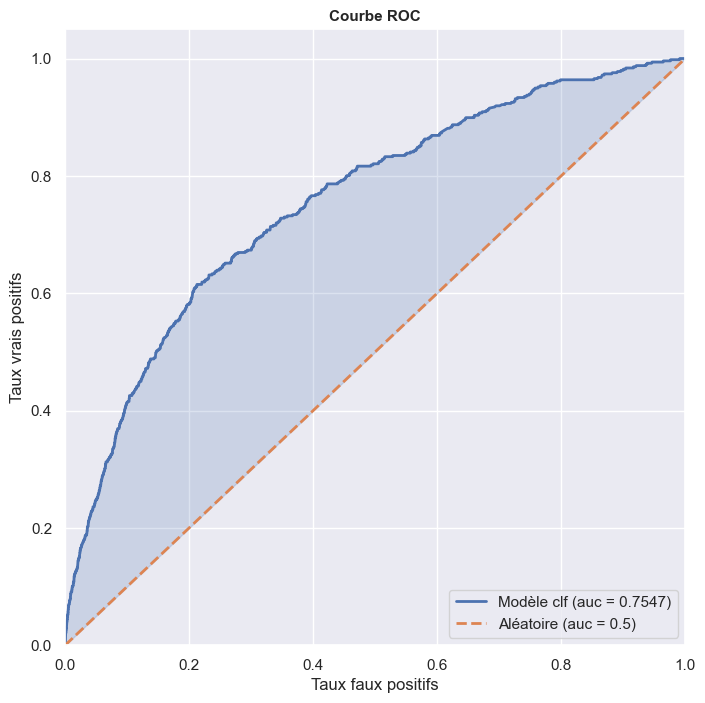

Performance sur le jeu d'entrainement (AUC) : 0.7546533350214022


In [13]:
# Performances sur l'échantillon test
lr_search.fit(X_train_t_dummy[modele_list], y_train)

auc_train = plot_roc_curve(lr_search, X_train_t_dummy[modele_list], y_train)
print(f"Performance sur le jeu d'entrainement (AUC) : {auc_train}")

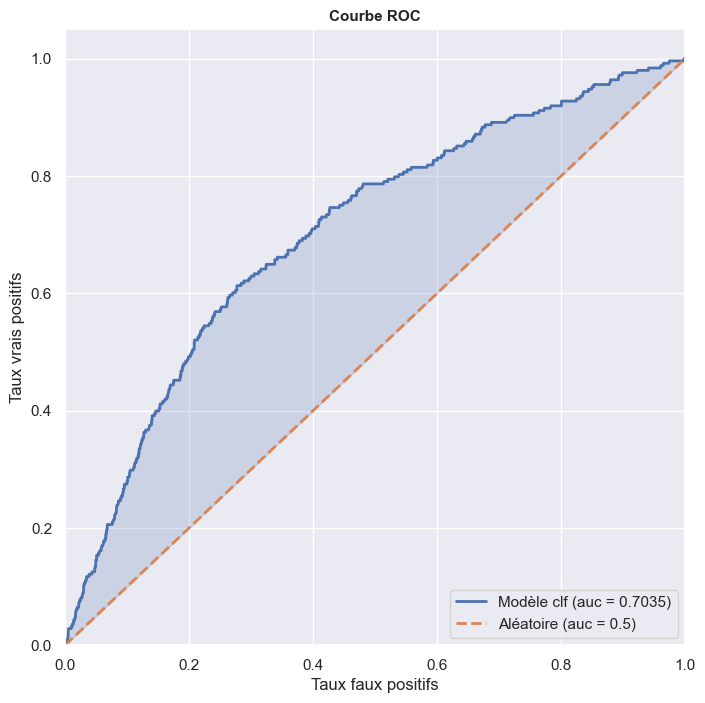

Performance sur le jeu de test (AUC) : 0.7034744472943681


In [14]:
auc_test = plot_roc_curve(lr_search, X_test_t_dummy[modele_list], y_test)
print(f"Performance sur le jeu de test (AUC) : {auc_test}")

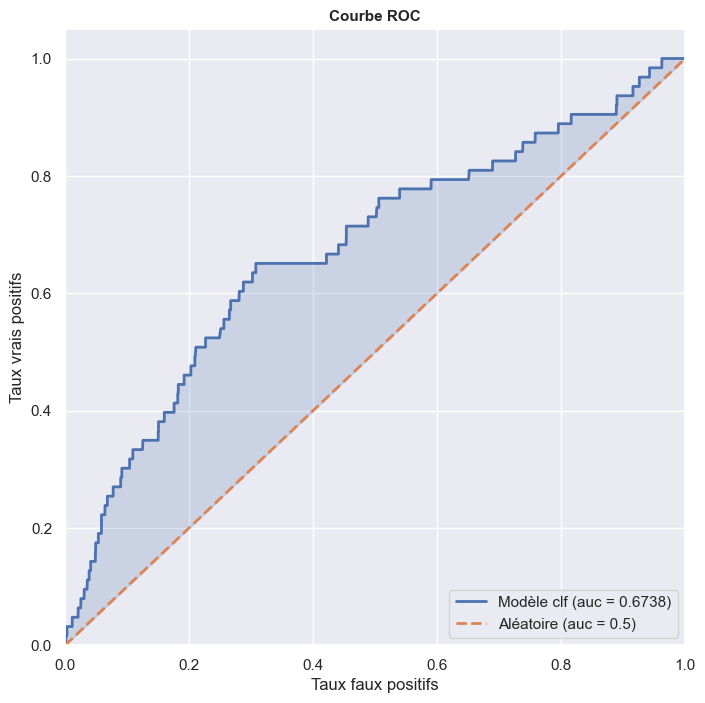

Performance sur le jeu out of sample (AUC) : 0.6737732222934016


In [15]:
# Performances sur l'échantillon out of sample
auc_oos = plot_roc_curve(lr_search, X_oos_t_dummy[modele_list], y_oos)
print(f"Performance sur le jeu out of sample (AUC) : {auc_oos}")

## Clustering en classes de risque & stabilité temporelle

### Choix du nombre de clusters

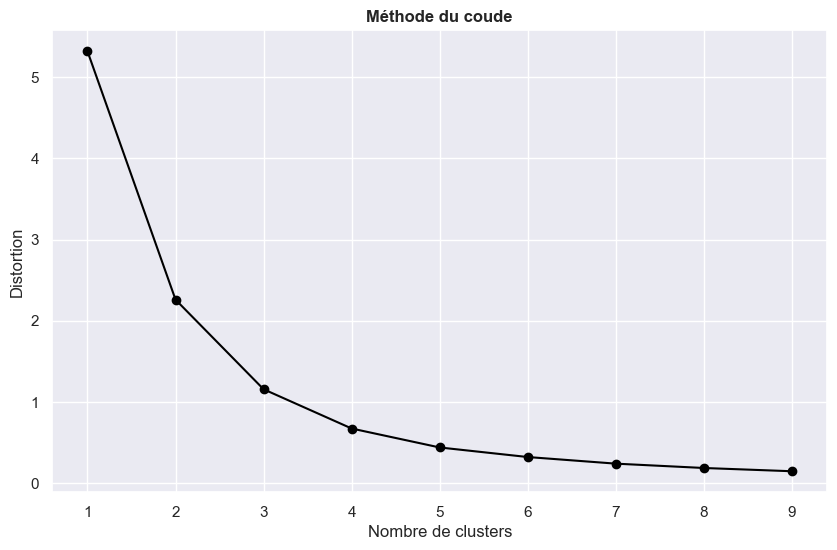

In [16]:
proba_indiv = lr_search.predict_proba(X_train_t_dummy[modele_list])[:, 1]
distortionList = list()

for i in range(1,10):
    kmeans = KMeans(n_clusters=i).fit(proba_indiv.reshape(-1, 1))
    distortionList.append(kmeans.inertia_)

plt.figure(figsize = (10, 6))
plt.title("Méthode du coude", fontweight = "bold")
plt.plot(distortionList, marker = "o", color = "black")
plt.ylabel("Distortion")
plt.xticks(ticks = np.arange(0, 9, 1), labels = np.arange(1, 10, 1))
plt.xlabel("Nombre de clusters")
plt.show()
# On retient 3 clusters

In [17]:
kmeans = KMeans(n_clusters=3).fit(proba_indiv.reshape(-1, 1))
X_train["Classe de risque"] = kmeans.labels_
X_test["Classe de risque"] = kmeans.predict((lr_search.predict_proba(X_test_t_dummy[modele_list])[:, 1]).reshape(-1, 1))
X_oos["Classe de risque"] = kmeans.predict((lr_search.predict_proba(X_oos_t_dummy[modele_list])[:, 1]).reshape(-1, 1))

concat_df = pd.concat([X_train, X_test, X_oos], axis = 0)
concat_df["defaut_36mois"] = pd.concat([y_train, y_test, y_oos], axis = 0)

def map_risque(risque):
    if risque == 1:
        return "Risque faible"
    elif risque == 2:
        return "Risque élevé"
    else:
        return "Risque moyen"

concat_df["Classe de risque"] = concat_df["Classe de risque"].map(map_risque)

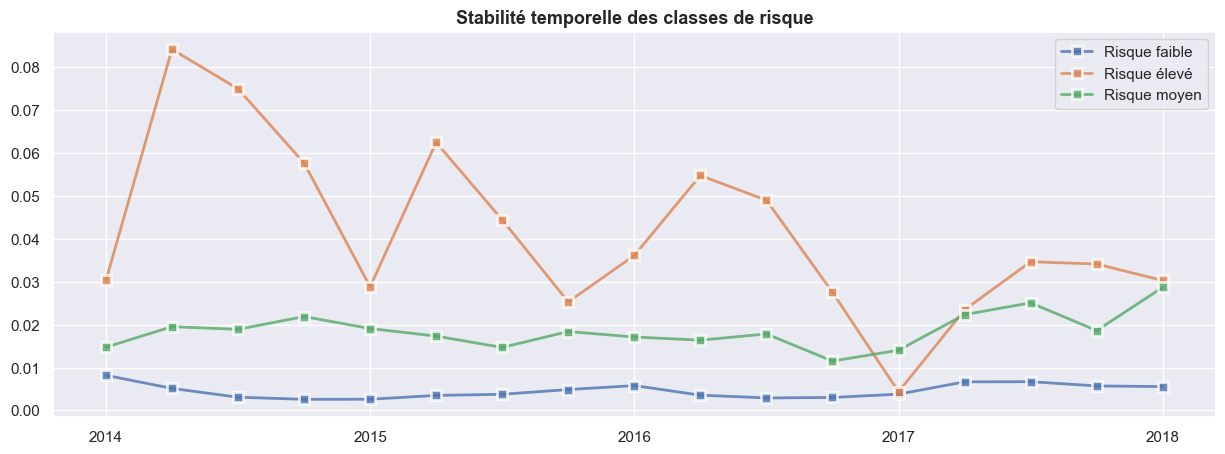

In [18]:
concat_df = create_date_periods(concat_df)

plt.figure(figsize = (15, 5))
plt.title("Stabilité temporelle des classes de risque", fontsize = 13, fontweight = "bold")

for modalite in concat_df["Classe de risque"].unique():
            plt.plot(concat_df[concat_df["Classe de risque"] == modalite][["defaut_36mois", "trimestre"]]
                .groupby(by="trimestre")
                .mean(),
                alpha=0.8,
                lw = 2,
                marker="s",
                markersize=7,
                markeredgecolor="white",
                markeredgewidth=2,
                label = modalite,
            )
            
plt.legend()
plt.xticks(ticks = np.arange(concat_df["trimestre"].min(), concat_df["trimestre"].max()+1, 4), labels = concat_df["annuel"].unique())
plt.show()

## Récupération des informations pour la grille de score

In [19]:
results = pd.DataFrame()
results["Modalité"] = lr_search.feature_names_in_
results["Coefficient"] = lr_search.coef_.T

var = results["Modalité"].apply(lambda x: x.split("[")[0][:-1])
mod = results["Modalité"].apply(lambda x: x.split("_")[-1])

coeff = dict()

for colonne in X_train_t_dummy.columns:
    if colonne in lr_search.feature_names_in_:
        coeff[colonne] = results[results["Modalité"] == colonne]["Coefficient"].values[0]
    else:
        coeff[colonne] = 0
        
nb = list()
for i in range(var.shape[0]):
    if "missin" in str(var[i]).lower():
        nb.append(0)
    else:
        nb.append(pd.concat([X_train_t, y_train], axis = 1).groupby(by = var[i])["defaut_36mois"].count().loc[mod[i]])
        
results["Variable"] = var
results["Modalités"] = mod
results["Effectif %"] = np.array(nb)/X_train_t.shape[0]

results
# results.to_excel("Résultats.xlsx")

,Modalité,Coefficient,Variable,Modalités,Effectif %
0,COD_CPPOP_CRI_[110 130],-0.675219,COD_CPPOP_CRI,[110 130],0.125684
1,COD_CPPOP_CRI_[60 20 90],0.356959,COD_CPPOP_CRI,[60 20 90],0.065836
2,COD_CPPOP_CRI_[70 40],-0.659211,COD_CPPOP_CRI,[70 40],0.367570
3,COD_ETA_BIEN_CRI_[ 70 110 120 130 40],-0.342805,COD_ETA_BIEN_CRI,[ 70 110 120 130 40],0.157483
4,COD_ETA_BIEN_CRI_[20 10],-0.867054,COD_ETA_BIEN_CRI,[20 10],0.139176
5,COD_ETA_BIEN_CRI_[50],-0.315904,COD_ETA_BIEN_CRI,[50],0.121182
6,IRPAR_USAGE_V12_MAX_[10. 1. 2.],-1.246849,IRPAR_USAGE_V12_MAX,[10. 1. 2.],0.599607
7,IRPAR_USAGE_V12_MAX_[3.],-1.110698,IRPAR_USAGE_V12_MAX,[3.],0.208668
8,IRPAR_USAGE_V12_MAX_[4. 5.],-0.659790,IRPAR_USAGE_V12_MAX,[4. 5.],0.110719
9,IRPAR_USAGE_V12_MAX_[6. 8. 7. 9.],0.000000,IRPAR_USAGE_V12_MAX,[6. 8. 7. 9.],0.080010


## Modèles challengers

[1]	training's auc: 0.754544	training's binary_logloss: 0.673731	valid_1's auc: 0.666055	valid_1's binary_logloss: 0.676797
[2]	training's auc: 0.765589	training's binary_logloss: 0.657745	valid_1's auc: 0.675022	valid_1's binary_logloss: 0.663178
[3]	training's auc: 0.785976	training's binary_logloss: 0.642159	valid_1's auc: 0.674322	valid_1's binary_logloss: 0.653662
[4]	training's auc: 0.79718	training's binary_logloss: 0.628429	valid_1's auc: 0.67614	valid_1's binary_logloss: 0.643464
[5]	training's auc: 0.801266	training's binary_logloss: 0.617109	valid_1's auc: 0.677081	valid_1's binary_logloss: 0.636825
[6]	training's auc: 0.807326	training's binary_logloss: 0.60529	valid_1's auc: 0.675573	valid_1's binary_logloss: 0.62732
[7]	training's auc: 0.808822	training's binary_logloss: 0.596628	valid_1's auc: 0.674184	valid_1's binary_logloss: 0.623271
[8]	training's auc: 0.810395	training's binary_logloss: 0.589192	valid_1's auc: 0.671848	valid_1's binary_logloss: 0.619128
[9]	training

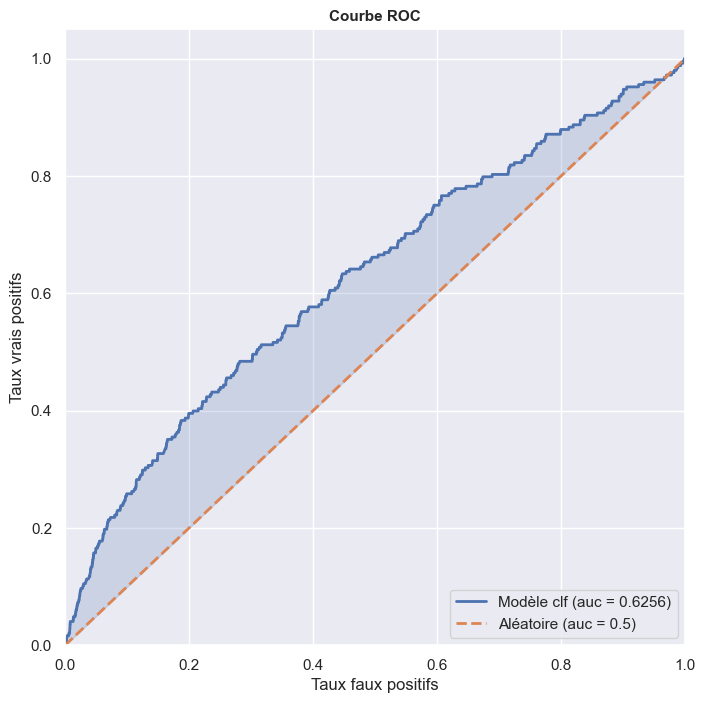

In [20]:
# LIGHT GBM
model = lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=22)


X_train2 = X_train_t_dummy.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test2 = X_test_t_dummy.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

model.fit(X_train2, y_train, eval_metric='auc', 
          eval_set=[(X_train2, y_train),(X_test2, y_test)])

prob_train = model.predict_proba(X_train2)
prob_test = model.predict_proba(X_test2)

auc_score_train = roc_auc_score(y_train, prob_train[:,1])
auc_score_test = roc_auc_score(y_test, prob_test[:,1])

print("\n \n")
print("Light GBM / Area Under Curve sur le jeu d'entrainement :", auc_score_train)
print("Light GBM / Area Under Curve sur le jeu de test :", auc_score_test)

_ = plot_roc_curve(model, X_test2, y_test)

LDA / Area Under Curve sur le jeu d'entrainement : 0.9389576623702879
LDA / Area Under Curve sur le jeu de test : 0.6256083814009965


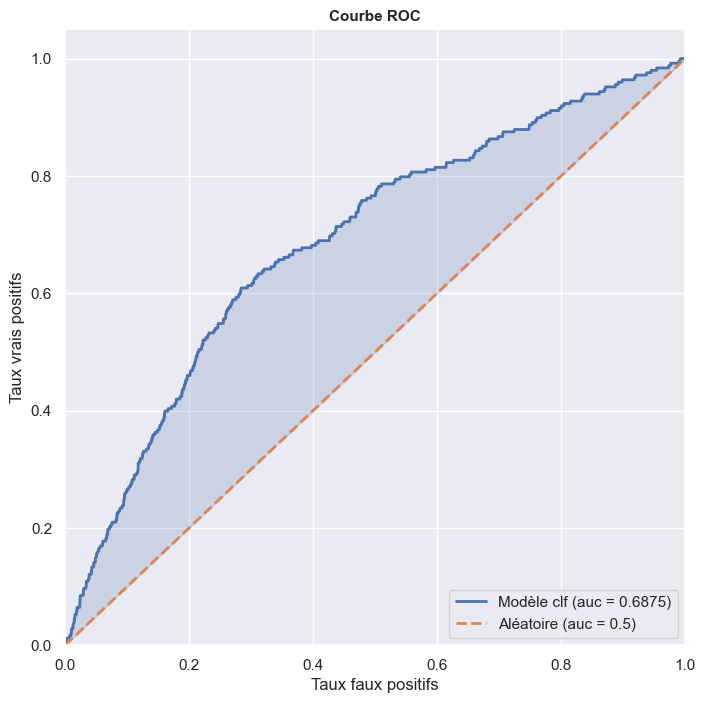

In [21]:
# Random Forest
rf = RandomForestClassifier(max_depth = 8, n_estimators = 100)
rf = rf.fit(X_train_t_dummy, y_train)

rf_prob_train = model.predict_proba(X_train_t_dummy)
rf_prob_test = model.predict_proba(X_test_t_dummy)

rf_auc_score_train = roc_auc_score(y_train, rf_prob_train[:,1])
rf_auc_score_test = roc_auc_score(y_test, rf_prob_test[:,1])

print("LDA / Area Under Curve sur le jeu d'entrainement :", rf_auc_score_train)
print("LDA / Area Under Curve sur le jeu de test :", rf_auc_score_test)

_ = plot_roc_curve(rf, X_test_t_dummy, y_test)

LDA / Area Under Curve sur le jeu d'entrainement : 0.756541197407906
LDA / Area Under Curve sur le jeu de test : 0.7050228151610247


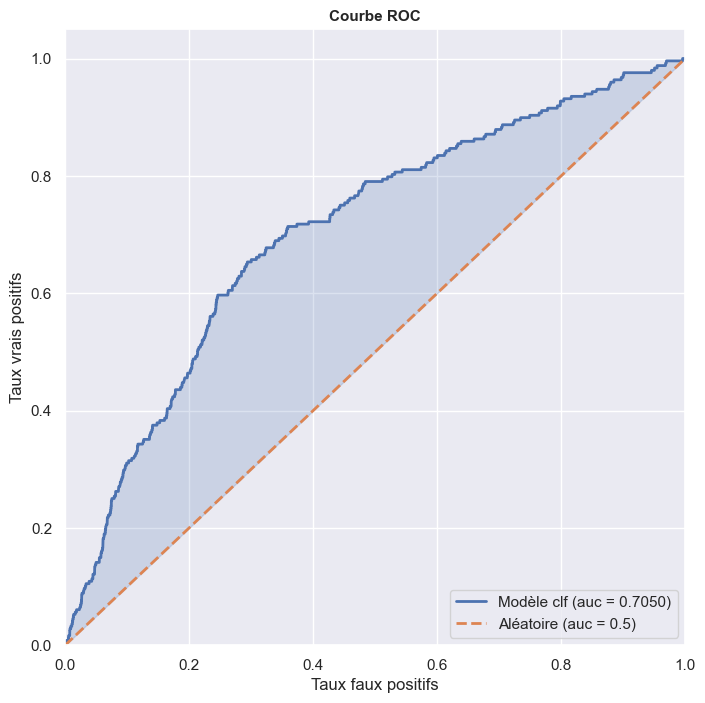

In [22]:
# Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis()
lda = lda.fit(X_train_t_dummy, y_train)

lda_prob_train = lda.predict_proba(X_train_t_dummy)
lda_prob_test = lda.predict_proba(X_test_t_dummy)

lda_auc_score_train = roc_auc_score(y_train, lda_prob_train[:,1])
lda_auc_score_test = roc_auc_score(y_test, lda_prob_test[:,1])

print("LDA / Area Under Curve sur le jeu d'entrainement :", lda_auc_score_train)
print("LDA / Area Under Curve sur le jeu de test :", lda_auc_score_test)

_ = plot_roc_curve(lda, X_test_t_dummy, y_test)

## Stabilité en effectif / risque des modalités

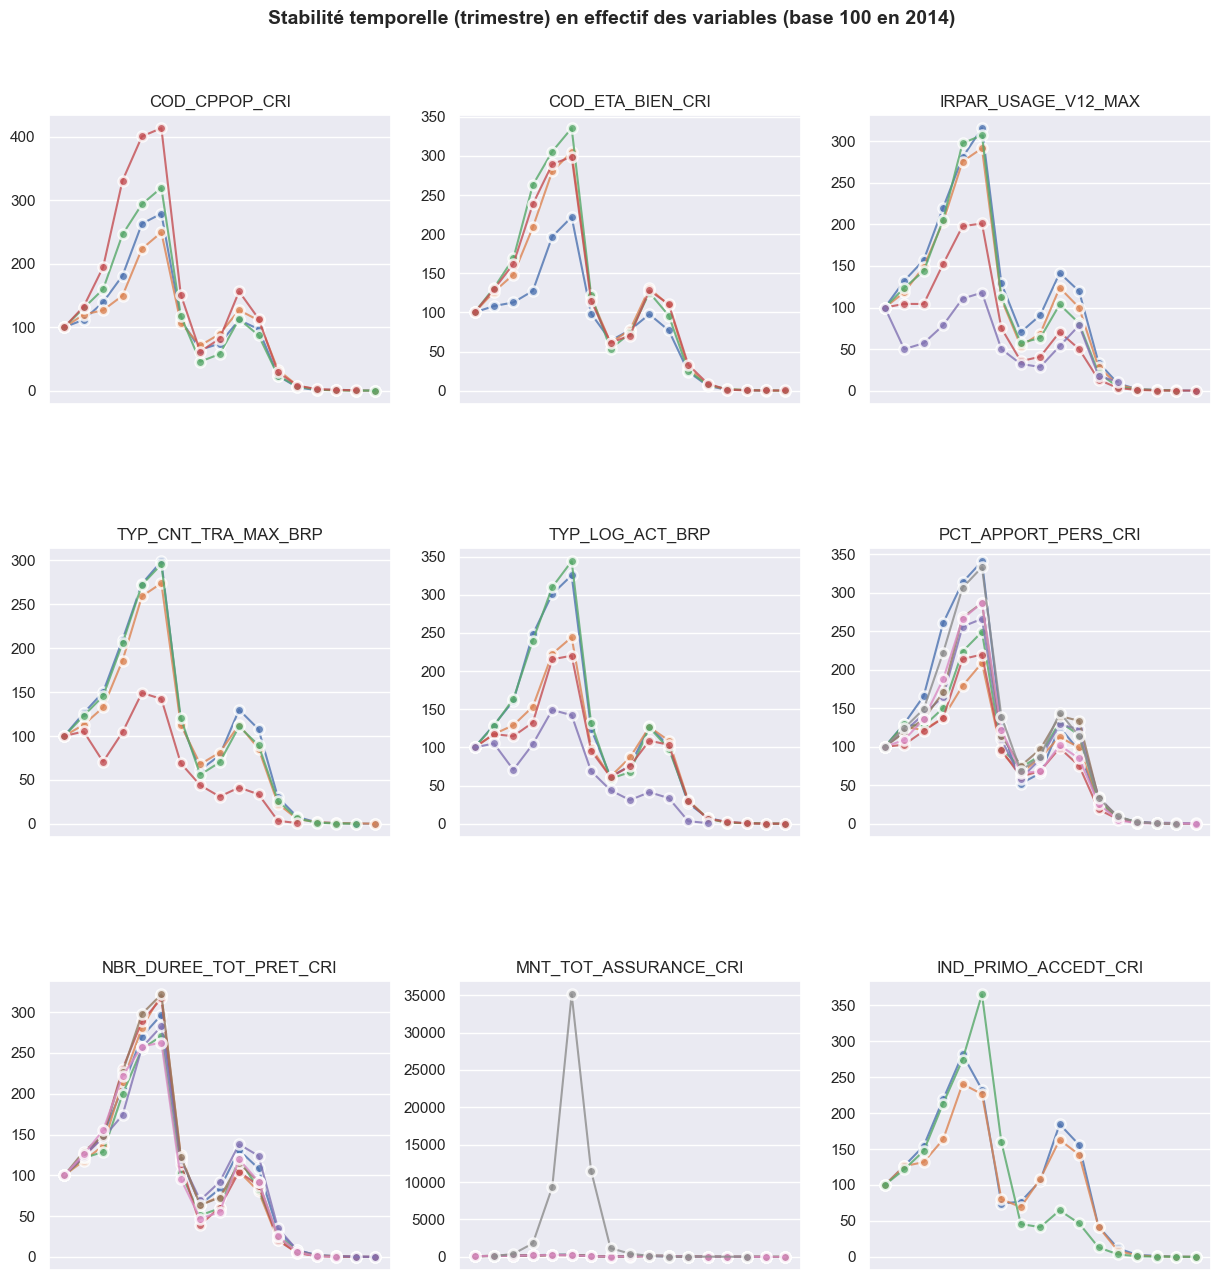

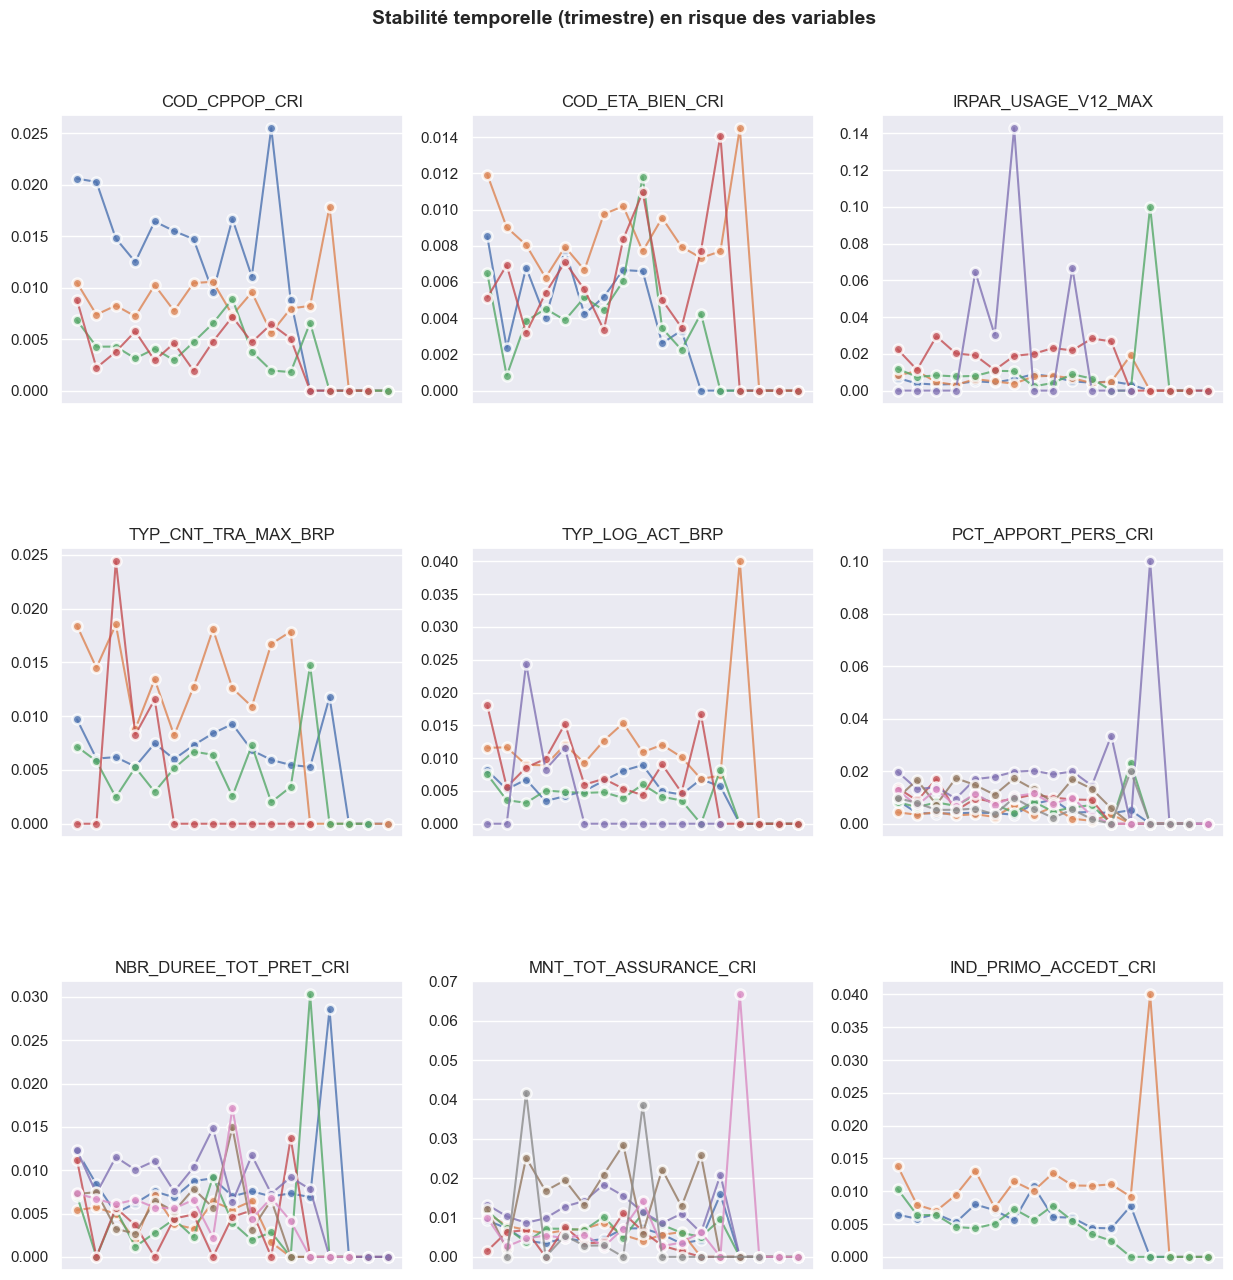

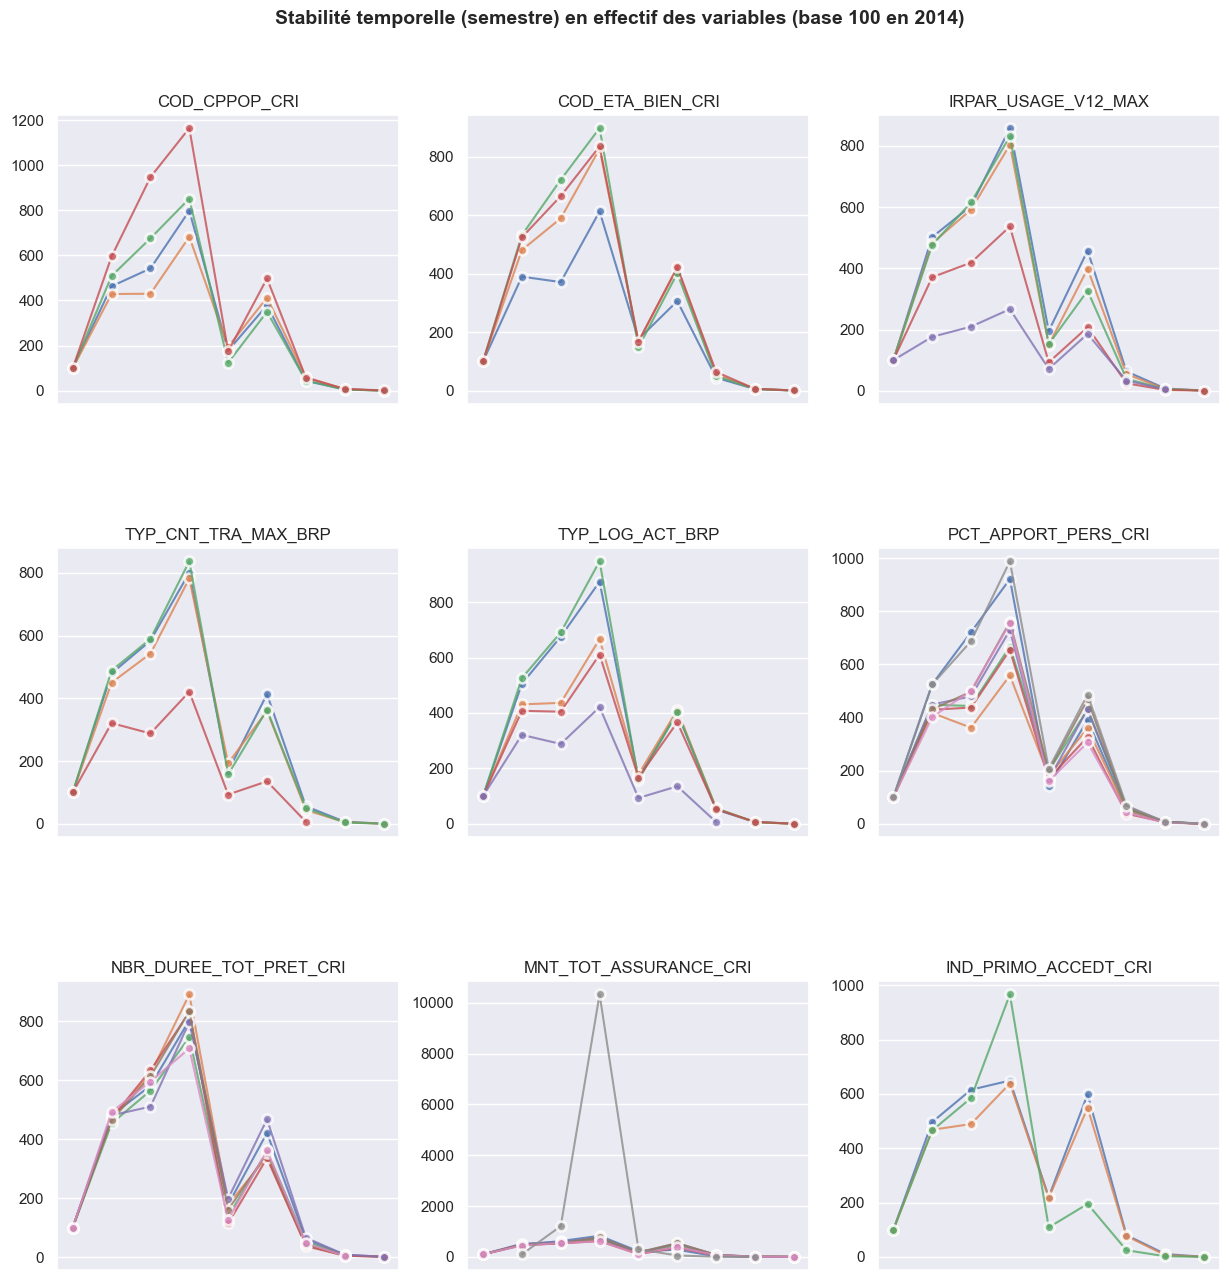

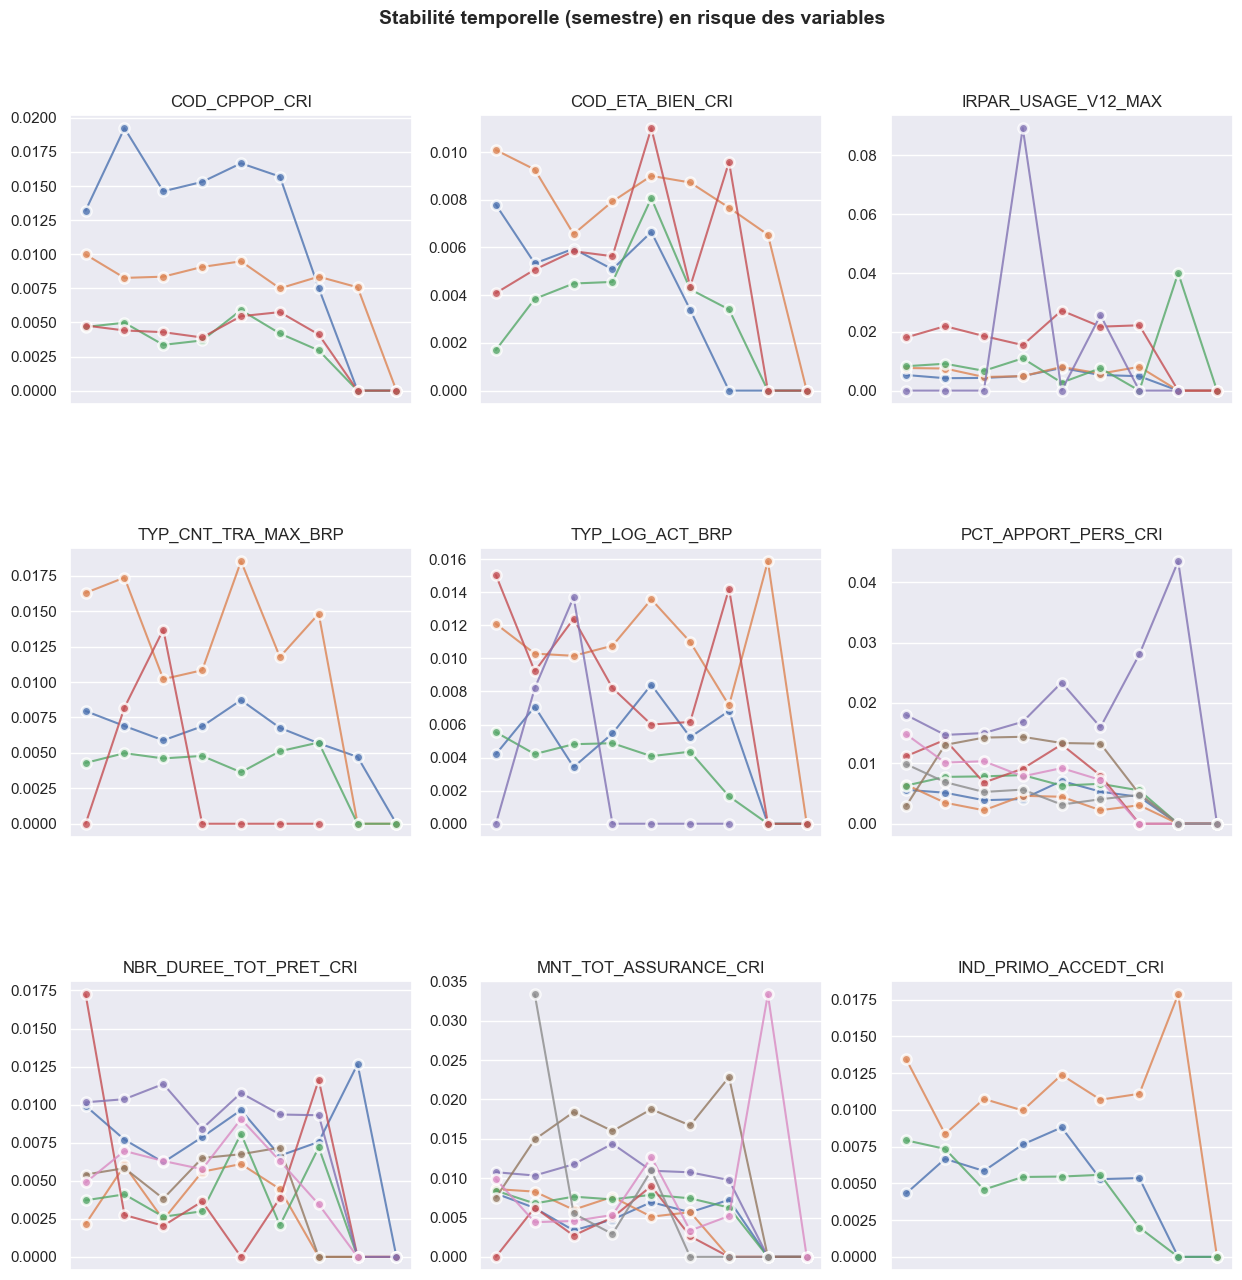

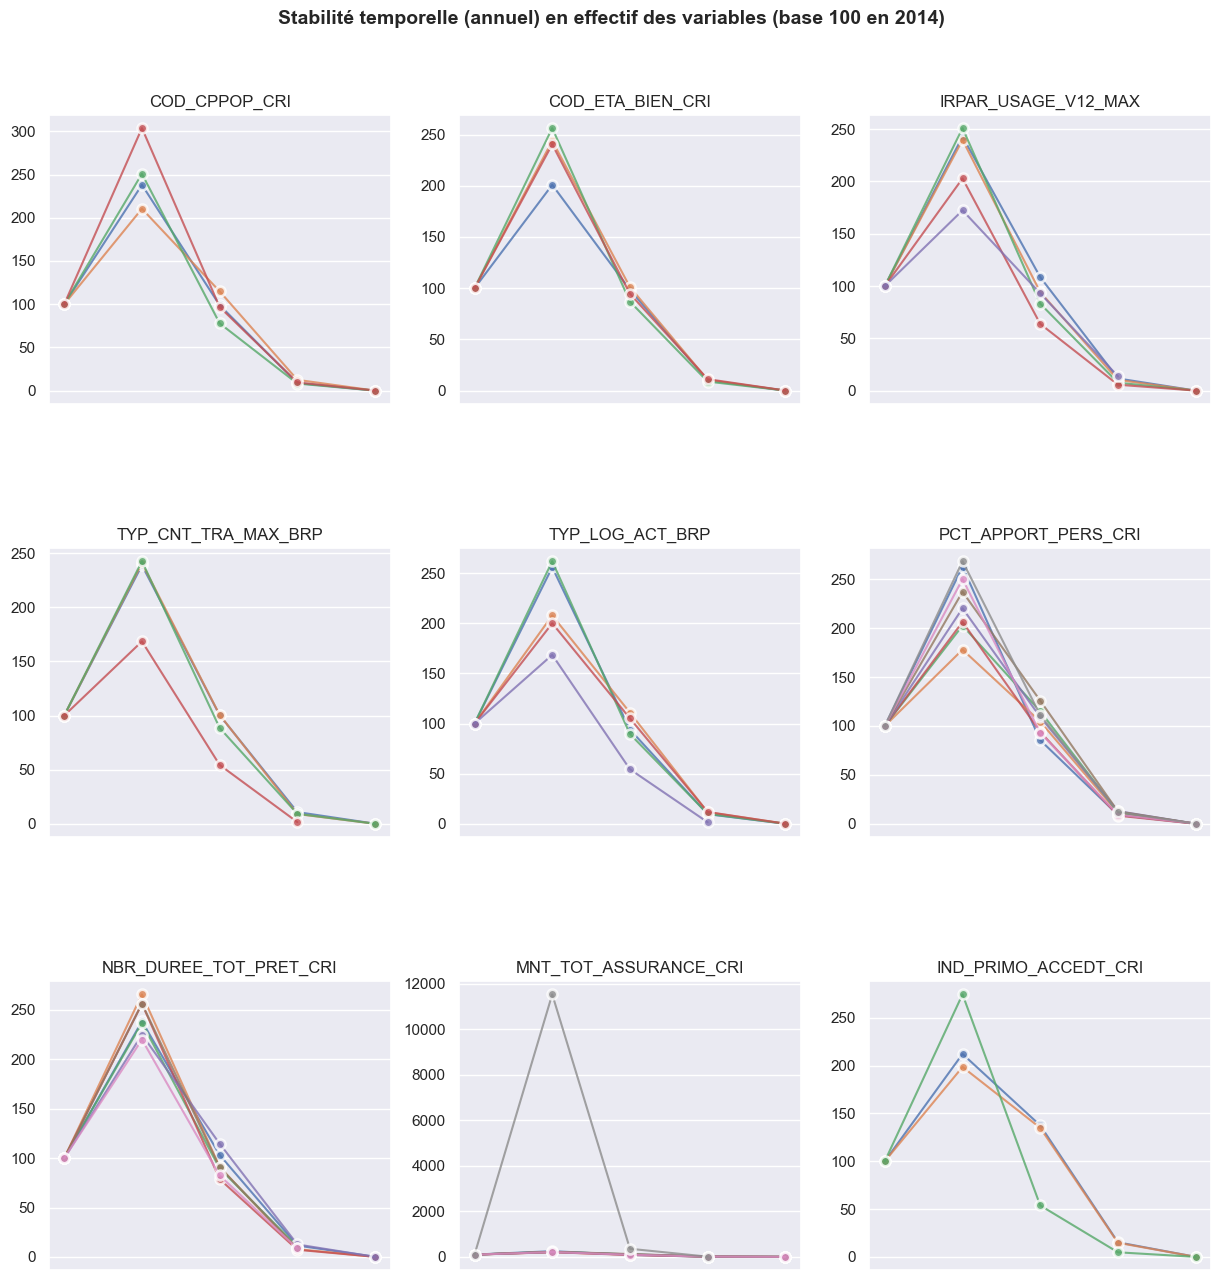

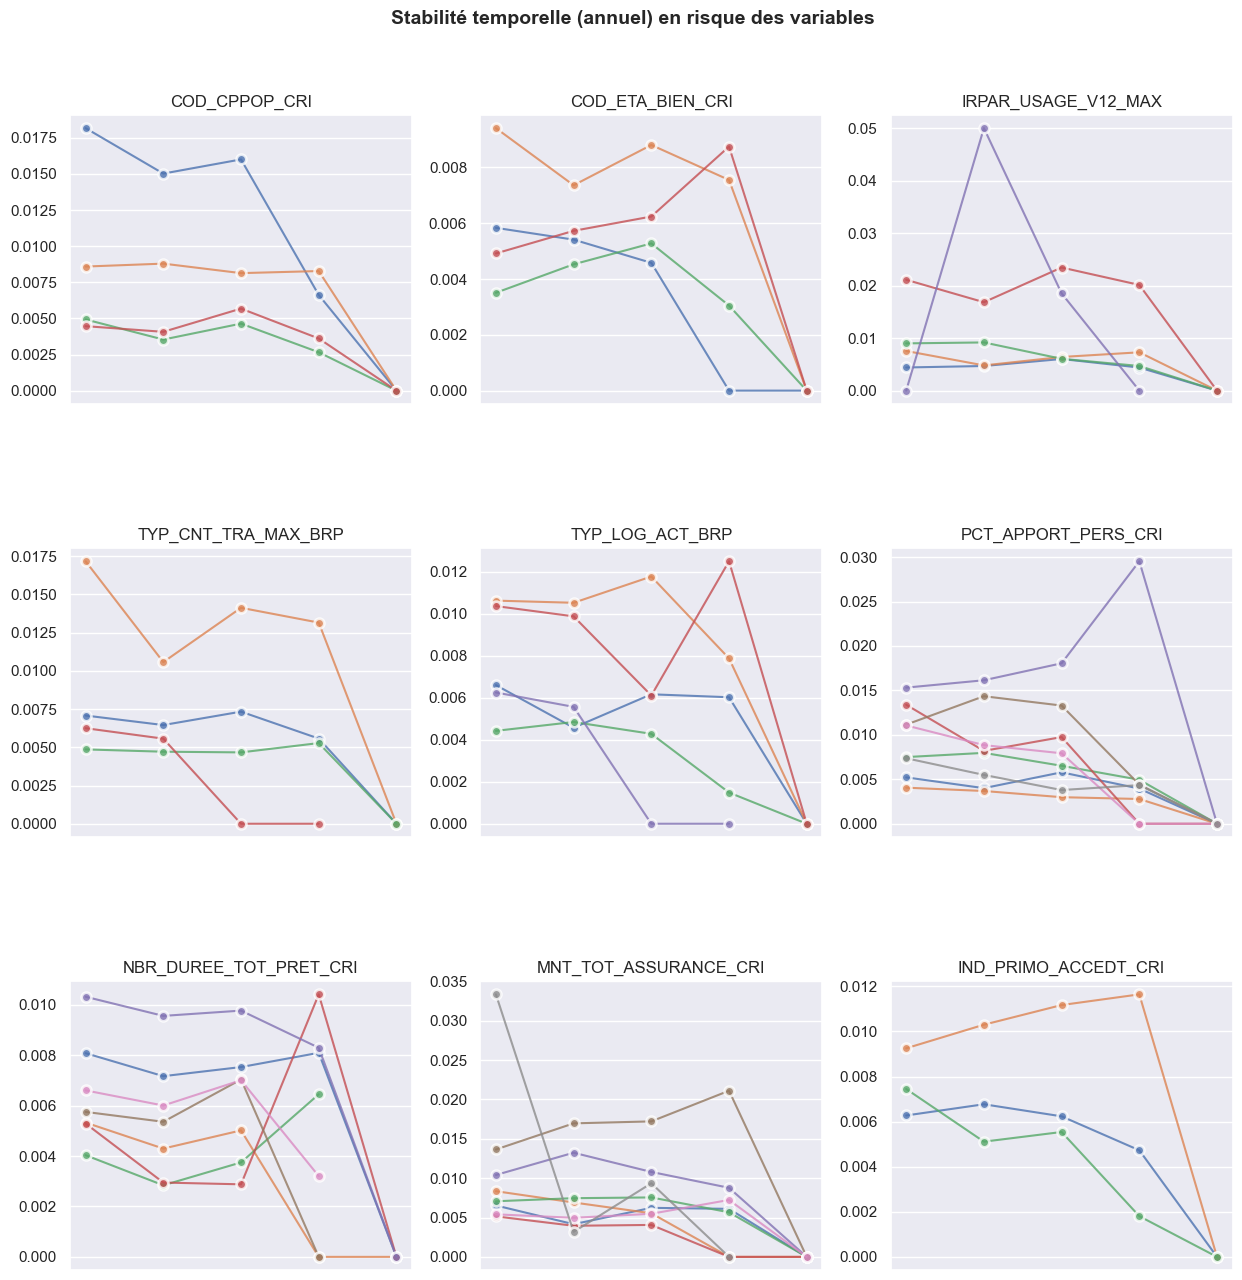

In [23]:
X_t = pd.concat([X_train_t, X_test_t], axis = 0)
columns_to_plot = X_t.columns

X_t["date_debloc_avec_crd"] = df["date_debloc_avec_crd"]

X_t = create_date_periods(X_t, "date_debloc_avec_crd")

for temporalite in ["trimestre", "semestre", "annuel"]:
    plot_stabilite_effectif(X_t, columns_to_plot, temporalite = temporalite)
    plot_stabilite_risque(X_t, pd.concat([y_train, y_test], axis = 0), columns_to_plot, temporalite = temporalite)